In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from torch.nn import functional as F
import configparser
import pandas as pd 

import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from os.path import join as oj
sys.path.insert(0, "../src")
from unet import UNet
import my_data
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
fig_path =config['PATHS']['figure_path'] 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# need exp with no active learning
# need exp with prop increasingf
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()


results.reset_index(inplace=True)

results[['foldername',  'cost_function', 'add_ratio',  'test_dice_score', 
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','add_ratio', 
         'foldername' ]).std()


test_dice_score
experiment_name     cost_function add_ratio foldername                   
AActiveLearning     cut_off_cost  0.010     lno_halfHour            0.002
                                  0.020     lno_halfHour            0.010
                                  0.050     lno_halfHour            0.001
                                  0.100     lno_halfHour            0.006
                    random_cost   0.010     lno_halfHour            0.011
                                  0.020     lno_halfHour            0.013
                                  0.050     lno_halfHour            0.004
                                  0.100     lno_halfHour            0.003
FullDatasetTraining random_cost   0.000     lno                     0.000
NoActiveLearning    random_cost   0.000     lno_halfHour            0.002

In [85]:
# make figure barplot
results_dict ={}
results_dict['No Aquisition'] = results[results.experiment_name == 'NoActiveLearning'].test_dice_score
results_dict['Random'] = results[results.cost_function == 'random_cost'][results.add_ratio == .02].test_dice_score
results_dict['Active Learning'] = results[results.cost_function == 'cut_off_cost'][results.add_ratio == .02].test_dice_score


results_dict['Full Dataset'] = results[results.experiment_name == 'FullDatasetTraining'].test_dice_score
# results_dict['Human repeat'] = np.asarray([0.9761262536048889])
for key in results_dict:
    results_dict[key] = np.asarray(results_dict[key])

C:\Users\lauri\AppData\Local\Temp\ipykernel_10296\1908655298.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Random'] = results[results.cost_function == 'random_cost'][results.add_ratio == .02].test_dice_score
C:\Users\lauri\AppData\Local\Temp\ipykernel_10296\1908655298.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Active Learning'] = results[results.cost_function == 'cut_off_cost'][results.add_ratio == .02].test_dice_score


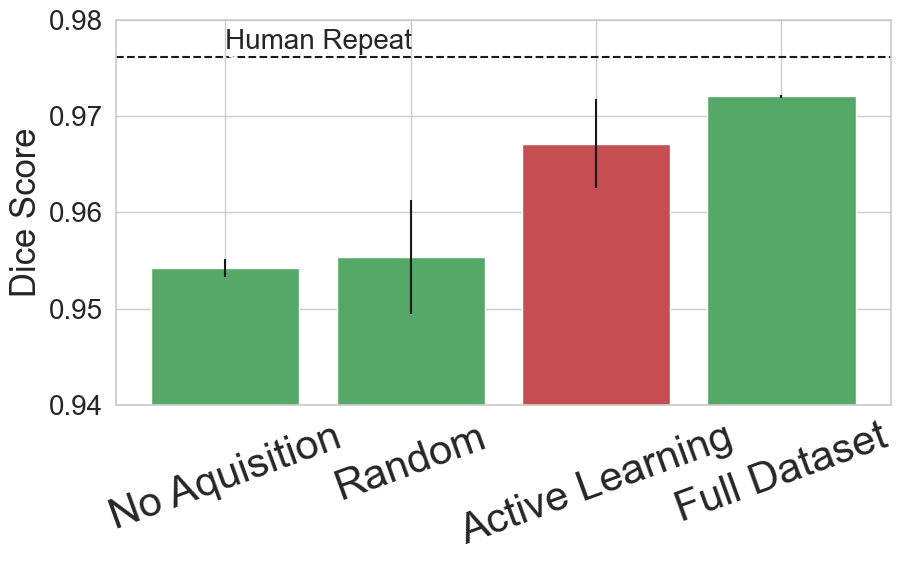

In [104]:
# make barplot
plt.figure(figsize=(10,5))
plt.bar(results_dict.keys(), 
        [np.mean(results_dict[key]) for key in results_dict.keys()], 
        yerr=[np.std(results_dict[key])/np.sqrt(len(results_dict[key])) for key in results_dict.keys()],
        # color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        color = ['g', 'g', 'r','g',])
# ticks
plt.xticks(fontsize=30, rotation=20)
plt.yticks([0.94, 0.95, 0.96, 0.97, 0.98], fontsize=20)
plt.axhline(0.9761262536048889, color='k', linestyle='--', label ='Human Repeat',)
# an arrow that points to the human repeat score and says "human repeat"
plt.annotate('Human Repeat', xy=(0, 0.9761262536048889), xytext=(0, 0.977), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20)

plt.ylim(0.94, 0.98)
plt.ylabel('Dice Score', fontsize=25)

# plt.legend(loc = 'center left', fontsize=20) 
plt.savefig(oj(fig_path, 'results_dice.pdf'), dpi=300, bbox_inches='tight')

<Figure size 1000x500 with 0 Axes>

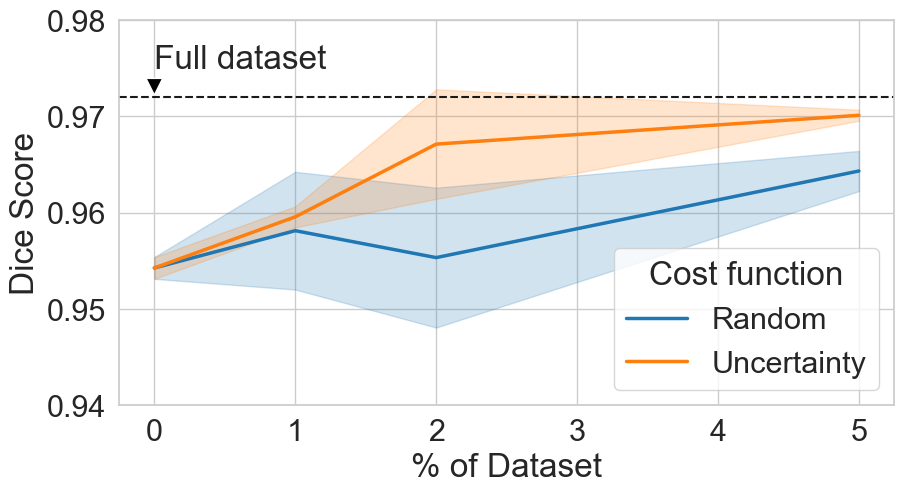

In [99]:
import seaborn as sns
#lineplot
results_here = results[results.experiment_name != 'FullDatasetTraining']
results_here_copy = results_here[results_here.add_ratio ==.0].copy()
results_here_copy.cost_function = 'cut_off_cost'
results_here = pd.concat([results_here, results_here_copy])
plt.figure(figsize=(10,5))
#rename 
results_here.cost_function = results_here.cost_function.replace('cut_off_cost', 'Uncertainty')
results_here.cost_function = results_here.cost_function.replace('random_cost', 'Random')
#make matplotlib
results_here = results_here[results_here.add_ratio < .1]
plt.figure(figsize=(10,5))

#rename column
results_here = results_here.rename(columns={'test_dice_score': 'Dice Score'})
results_here.add_ratio = results_here.add_ratio*100
results_here = results_here.rename(columns={'cost_function': 'Cost function'})
results_here = results_here.rename(columns={'add_ratio': '% of Dataset'})

#increase font size for seaborm
sns.set(font_scale=2)
sns.set_style("whitegrid")
# sns.despine(offset=10, trim=True);
sns.lineplot(data=results_here, x="% of Dataset", y="Dice Score", hue="Cost function", errorbar='se', palette="tab10", linewidth=2.5)
# plt.savefig(oj(fig_path, 'forloeb.png'), dpi=300, bbox_inches='tight')
plt.ylim(.94, .98)
# plt.axhline(0.9761262536048889, color='k', linestyle='--', label ='Human Repeat',)
plt.axhline(0.972, color='k', linestyle='--', label ='Full dataset',)

# an arrow that points to the h line and says "Full dataset"
plt.annotate('Full dataset', xy=(0, 0.972), xytext=(0, 0.975),
             arrowprops=dict(facecolor='black', shrink=0.1),
             )

# savefig
plt.savefig(oj(fig_path, 'results_lineplot.pdf'), dpi=300, bbox_inches='tight')

In [13]:
results = results[results['cost_function'] == 'cut_off_cost']
results = results[results['experiment_name'] == 'ActiveLearningRandomChoose']
#reindex
results = results.reset_index(drop=True)

In [14]:
 results.data_min

Series([], Name: data_min, dtype: float64)

In [ ]:
x, y, num_classes, class_dict = my_data.load_layer_data( oj(config["DATASET"]["data_path"], 'lno') )
x_test, y_test = x[-1:], y[-1:]
x_test = (x_test - results.data_min[0]) / (results.data_max[0] - results.data_min[0])
num_classes = results.num_classes[0]

In [ ]:
x, y, num_classes, class_dict = my_data.load_layer_data( oj(config["DATASET"]["data_path"], 'lno') )
x_test, y_test = x[-1:], y[-1:]
x_test = (x_test - results.data_min[0]) / (results.data_max[0] - results.data_min[0])
num_classes = results.num_classes[0]

In [ ]:
net = UNet(1, results.num_classes[0], )


In [ ]:
x_test, y_test = my_data.stack_imgs(x_test, y_test)

In [ ]:
from tqdm import tqdm

In [ ]:
for j in tqdm(range(len(results))):
    # if the file exists
    if os.path.exists(oj(config['PATHS']['model_path'] ,results.file_name[j]+".pt")):
        
        net = UNet(1, results.num_classes[0], )
        net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[j]+".pt")))
        print(results.cost_function[j])
        net = net.to(device).eval()
        results.at[j, 'test_dice_score'] = evaluate.final_evaluate(net, x_test, y_test, num_classes, device)
        break

In [ ]:
results[['foldername',  
         'test_dice_score','cost_function', 'add_ratio',
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).mean()

In [ ]:
x_pool = my_data.load_pool_data( oj(config["DATASET"]["data_path"], 'lno') )
x_pool = x_pool[:-4]
x_pool = (x_pool.astype(np.float16) - results.data_min[0]) / (results.data_max[0] - results.data_min[0])
x_pool_all, slice_numbers = my_data.make_dataset_single( x_pool, 
                                                 img_size=128, 
                                                 offset=128,
                                                  return_slice_numbers= True )
     
pool_set = TensorDataset(torch.Tensor(x_pool_all))
loader_args = dict( batch_size=4, num_workers=0, pin_memory=True )
pool_loader = DataLoader(pool_set, shuffle=False, **loader_args)

In [ ]:
x_pool.shape

In [ ]:
idx = 369
plt.imshow(pool_loader.dataset[idx][0][0], )

In [ ]:
output = F.softmax(net.forward(pool_loader.dataset[idx][0][None,:].to(device)), dim=1)[:,:, 4:-4, 4:-4]
plt.imshow((-torch.sum(output * torch.log(output), dim=1))[0].detach().cpu())
print((-torch.sum(output * torch.log(output), dim=1))[0].detach().cpu().mean())

In [ ]:
plt.plot((-torch.sum(output * torch.log(output), dim=1))[0].detach().cpu().reshape(-1).sort()[0])

In [ ]:
net = net.to(device)
net.eval()
evaluate.cut_off_cost(net, device, pool_loader, percentile=.5,  n_choose=5)

In [ ]:
net.forward(img_t).shape

In [ ]:
img_idx = 1
test_img_np  = ((x_test[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t), dim =1).cpu().detach().numpy()[0]

In [ ]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x_test[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y_test[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))

axes[4].imshow( (-output * np.log(output)).sum(axis=0))
# axes[1].imshow()

# try with detailed

In [ ]:
x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [ ]:
val_loader.batch_size

In [ ]:
x_small, _,=my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )

In [ ]:
x_small[test_idxes].min()

In [ ]:
net(t)

In [ ]:
x.shape

In [ ]:
val_loader

In [ ]:
net

In [ ]:
len(all_train_idxs)

In [ ]:
len(val_loader.dataset)

In [ ]:
plt.imshow(x[val_idxs[0]][0])

In [ ]:
test_ids_safe = std_cost_function(net, device,val_loader,n_choose =59)

# test_ids = np.argsort(test_ids_safe)

In [ ]:
len(val_loader.dataset)

In [ ]:
test_ids_safe

In [ ]:
plt.imshow(val_set[test_ids_safe[0]][0][0])

In [ ]:
plt.imshow(val_set[test_ids_safe[-20]][0][0])

In [ ]:
test_ids_safe[32]

In [ ]:
test_ids_safe[23]

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
net(val_set[test_ids_safe[1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][0].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][2].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1)

In [ ]:
test_ids_safe[224]

In [ ]:
len(test_ids_safe)

In [ ]:
test_ids = np.sort(test_ids)

In [ ]:
plt.imshow(val_set[5][0][0])

In [ ]:
plt.imshow(val_set[test_ids[10]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[1]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[0]][0][0])

In [ ]:
img_idx = 0
test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t)[0], dim =0).cpu().detach().numpy()


In [ ]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ))
max_val =np.quantile(output.std(axis=0).max() - output.std(axis=0),.90)
axes[4].imshow(output.std(axis=0).max() - output.std(axis=0),vmax = max_val)
# axes[1].imshow()

In [ ]:
output.std(axis=0).max() - output.std(axis=0)

In [ ]:
with torch.no_grad():
    img_t = torch.Tensor(x[val_idxs]).to(device)
    output = F.softmax(net.forward(img_t), dim =1)


In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std < np.quantile(my_std, .1)))].mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std > np.quantile(my_std, .1)))].mean()

In [ ]:
len(val_loader)

In [ ]:
val_loader

In [ ]:
eva

In [ ]:
my_std = torch.std(output,dim =1).detach().cpu().numpy()

In [ ]:
torch.argmax(output, dim = 1)

In [ ]:
np.where((my_std < np.quantile(my_std, .1)))

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
output.shape

In [ ]:
1-dice_loss(output, torch.Tensor(y[val_idxs]).to(device), num_classes, multiclass=True)

In [ ]:
from dice_score import dice_loss

In [ ]:
dice_loss()

In [ ]:
num_classes

In [ ]:
np.quantile(output.std(axis=0).max() - output.std(axis=0), .9)

In [ ]:
output.std(axis=0).max()

In [ ]:
(target ==np.argmax(output, axis=0) ).mean()

In [ ]:
output.std(axis=0)

# old stuff

In [ ]:
for i in range(4):
    img_idx = i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        show_img = np.zeros_like(y[img_idx])
        show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
        show_img[np.where(y[img_idx] ==my_data.phase_2)] =2
        print((show_img ==np.argmax(output, axis=0)).mean())


In [ ]:
img_idx = -1
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


In [ ]:
show_img = np.zeros_like(y[img_idx])
show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
show_img[np.where(y[img_idx] ==my_data.phase_2)] =2

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .05)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0))
# axes[2].imshow(show_img)
axes[1].imshow(show_img !=np.argmax(output, axis=0) )

axes[2].imshow(std_large)

In [ ]:
(show_img !=np.argmax(output, axis=0))[np.where(1-std_large)].mean()

In [ ]:
(show_img ==np.argmax(output, axis=0)).mean()

In [ ]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0,2])

In [ ]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]